# Compare GPs + Plot

In [1]:
import fastgp
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot
import tueplots.figsizes

In [2]:
torch.set_default_dtype(torch.float64)
device = "cpu"

In [3]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]


## True Function

In [4]:
d = 1
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768):
    # https://www.sfu.ca/~ssurjano/ackley.html
    assert x.ndim==2
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y

## Parameters

In [5]:
n = 2**2
xticks = torch.linspace(0,1,501,device=device)
yticks = f_ackley(xticks[:,None])

## Standard GP

In [6]:
print("  n = %d"%n)
sgp = fastgp.StandardGP(
    qp.DigitalNetB2(dimension=d,seed=11),
    device = device,
    )
x_next = sgp.get_x_next(n)
y_next = f_ackley(x_next)
sgp.add_y_next(y_next)
sgp.fit()
pmean_std_n,pstd_std_n,q,ci_low_std_n,ci_high_std_n = sgp.post_ci(xticks[:,None])
x_std_n,y_std_n = sgp.x.clone(),sgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (sgp.post_cubature_var(),2*n,sgp.post_cubature_var(n=2*n),4*n,sgp.post_cubature_var(n=4*n)))

  n = 4
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.19e+05   | 2.38e+05   | -1.25e+01 
            5.00e+00 | 1.39e+04   | 2.77e+04   | -6.26e+00 
            1.00e+01 | 6.13e+01   | 1.07e+02   | 8.42e+00  
            1.50e+01 | 1.66e+01   | 3.27e+00   | 2.27e+01  
            2.00e+01 | 1.65e+01   | 3.39e+00   | 2.22e+01  
            2.40e+01 | 1.65e+01   | 3.81e+00   | 2.17e+01  
    posterior cubature var: 2.38e+00   n=8: 3.89e-03   n=16: 1.09e-05  


In [7]:
print("  n = %d"%(2*n))
x_next = sgp.get_x_next(2*n)
y_next = f_ackley(x_next)
sgp.add_y_next(y_next)
sgp.fit()
pmean_std_2n,pstd_std_2n,q,ci_low_std_2n,ci_high_std_2n = sgp.post_ci(xticks[:,None])
x_std_2n,y_std_2n = sgp.x.clone(),sgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (sgp.post_cubature_var(),4*n,sgp.post_cubature_var(n=4*n),8*n,sgp.post_cubature_var(n=8*n)))

  n = 8
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 3.69e+02   | 7.05e+02   | 1.78e+01  
            5.00e+00 | 3.09e+01   | 1.11e+01   | 3.60e+01  
            1.00e+01 | 2.94e+01   | 7.35e+00   | 3.68e+01  
            1.50e+01 | 2.86e+01   | 9.03e+00   | 3.35e+01  
            2.00e+01 | 2.86e+01   | 8.12e+00   | 3.43e+01  
            2.10e+01 | 2.86e+01   | 7.68e+00   | 3.48e+01  
    posterior cubature var: 4.74e-01   n=16: 1.37e-04   n=32: 3.45e-06  


In [8]:
print("  n = %d"%(4*n))
x_next = sgp.get_x_next(4*n)
assert x_next.shape==(2*n,1)
y_next = f_ackley(x_next)
sgp.add_y_next(y_next)
sgp.fit()
pmean_std_4n,pstd_std_4n,q,ci_low_std_4n,ci_high_std_4n = sgp.post_ci(xticks[:,None])
x_std_4n,y_std_4n = sgp.x.clone(),sgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (sgp.post_cubature_var(),8*n,sgp.post_cubature_var(n=8*n),16*n,sgp.post_cubature_var(n=16*n)))

  n = 16
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 9.63e+03   | 1.92e+04   | 1.40e+01  
            5.00e+00 | 6.24e+01   | 3.25e+01   | 6.28e+01  
            1.00e+01 | 5.44e+01   | 1.27e+01   | 6.66e+01  
            1.50e+01 | 5.27e+01   | 1.78e+01   | 5.82e+01  
            2.00e+01 | 5.26e+01   | 1.61e+01   | 5.97e+01  
            2.30e+01 | 5.26e+01   | 1.61e+01   | 5.98e+01  
    posterior cubature var: 3.43e-02   n=32: 9.12e-06   n=64: 1.62e-06  


## Lattice

In [9]:
print("  n = %d"%n)
fgp = fastgp.FastGPLattice(
    qp.Lattice(dimension=d,seed=7),
    device = device,
    )
x_next = fgp.get_x_next(n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_lattice_n,pstd_lattice_n,q,ci_low_lattice_n,ci_high_lattice_n = fgp.post_ci(xticks[:,None])
x_lattice_n,y_lattice_n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),2*n,fgp.post_cubature_var(n=2*n),4*n,fgp.post_cubature_var(n=4*n)))

  n = 4
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.13e+02   | 4.15e+02   | 3.52e+00  
            5.00e+00 | 9.45e+01   | 1.73e+02   | 8.74e+00  
            1.00e+01 | 2.58e+01   | 2.24e+01   | 2.18e+01  
            1.50e+01 | 1.82e+01   | 4.21e+00   | 2.48e+01  
            2.00e+01 | 1.56e+01   | 5.28e+00   | 1.86e+01  
            2.50e+01 | 1.56e+01   | 4.81e+00   | 1.90e+01  
            2.80e+01 | 1.55e+01   | 4.22e+00   | 1.95e+01  
    posterior cubature var: 2.93e-01   n=8: 1.83e-02   n=16: 1.15e-03  


In [10]:
print("  n = %d"%(2*n))
x_next = fgp.get_x_next(2*n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_lattice_2n,pstd_lattice_2n,q,ci_low_lattice_2n,ci_high_lattice_2n = fgp.post_ci(xticks[:,None])
x_lattice_2n,y_lattice_2n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),4*n,fgp.post_cubature_var(n=4*n),8*n,fgp.post_cubature_var(n=8*n)))

  n = 8
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.46e+01   | 6.67e+00   | 2.79e+01  
            5.00e+00 | 2.45e+01   | 8.23e+00   | 2.61e+01  
            1.00e+01 | 2.45e+01   | 8.76e+00   | 2.55e+01  
    posterior cubature var: 1.30e-02   n=16: 8.13e-04   n=32: 5.08e-05  


In [11]:
print("  n = %d"%(4*n))
x_next = fgp.get_x_next(4*n)
assert x_next.shape==(2*n,1)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_lattice_4n,pstd_lattice_4n,q,ci_low_lattice_4n,ci_high_lattice_4n = fgp.post_ci(xticks[:,None])
x_lattice_4n,y_lattice_4n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),8*n,fgp.post_cubature_var(n=8*n),16*n,fgp.post_cubature_var(n=16*n)))

  n = 16
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 4.84e+01   | 4.45e+01   | 2.29e+01  
            5.00e+00 | 4.23e+01   | 1.56e+01   | 3.96e+01  
            1.00e+01 | 4.23e+01   | 1.54e+01   | 3.98e+01  
            1.30e+01 | 4.23e+01   | 1.58e+01   | 3.94e+01  
    posterior cubature var: 2.30e-03   n=32: 1.44e-04   n=64: 8.97e-06  


## Digital Net

In [12]:
print("  n = %d"%n)
fgp = fastgp.FastGPDigitalNetB2(
    qp.DigitalNetB2(dimension=1,seed=7),
    device = device,
    )
x_next = fgp.get_x_next(n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_dnb2_n,pstd_dnb2_n,q,ci_low_dnb2_n,ci_high_dnb2_n = fgp.post_ci(xticks[:,None])
x_dnb2_n,y_dnb2_n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),2*n,fgp.post_cubature_var(n=2*n),4*n,fgp.post_cubature_var(n=4*n)))

  n = 4
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.62e+02   | 3.13e+02   | 2.82e+00  
            5.00e+00 | 6.53e+01   | 1.15e+02   | 8.23e+00  
            1.00e+01 | 1.78e+01   | 5.99e+00   | 2.23e+01  
            1.50e+01 | 1.79e+01   | 6.69e+00   | 2.18e+01  
            2.00e+01 | 1.77e+01   | 4.99e+00   | 2.30e+01  
    posterior cubature var: 1.38e+01   n=8: 1.04e+01   n=16: 2.40e+00  


In [13]:
print("  n = %d"%(2*n))
x_next = fgp.get_x_next(2*n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_dnb2_2n,pstd_dnb2_2n,q,ci_low_dnb2_2n,ci_high_dnb2_2n = fgp.post_ci(xticks[:,None])
x_dnb2_2n,y_dnb2_2n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),4*n,fgp.post_cubature_var(n=4*n),8*n,fgp.post_cubature_var(n=8*n)))

  n = 8
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 3.46e+01   | 7.88e+00   | 4.66e+01  
            5.00e+00 | 3.40e+01   | 1.16e+01   | 4.16e+01  
            1.00e+01 | 3.22e+01   | 1.09e+01   | 3.89e+01  
            1.50e+01 | 3.08e+01   | 1.18e+01   | 3.50e+01  
            2.00e+01 | 3.04e+01   | 8.94e+00   | 3.72e+01  
            2.50e+01 | 3.03e+01   | 8.34e+00   | 3.76e+01  
            2.60e+01 | 3.03e+01   | 8.66e+00   | 3.73e+01  
    posterior cubature var: 5.83e+00   n=16: 6.21e-01   n=32: 3.52e-01  


In [14]:
print("  n = %d"%(4*n))
x_next = fgp.get_x_next(4*n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_dnb2_4n,pstd_dnb2_4n,q,ci_low_dnb2_4n,ci_high_dnb2_4n = fgp.post_ci(xticks[:,None])
x_dnb2_4n,y_dnb2_4n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),8*n,fgp.post_cubature_var(n=8*n),16*n,fgp.post_cubature_var(n=16*n)))

  n = 16
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 5.50e+01   | 1.11e+01   | 6.95e+01  
            5.00e+00 | 5.42e+01   | 1.74e+01   | 6.16e+01  
            1.00e+01 | 5.39e+01   | 1.62e+01   | 6.22e+01  
            1.20e+01 | 5.41e+01   | 2.03e+01   | 5.85e+01  
    posterior cubature var: 3.69e-01   n=32: 2.09e-01   n=64: 1.52e-02  


## Collect Data + Plot

In [15]:
data = [
    [
        (x_std_n,y_std_n,pmean_std_n,ci_low_std_n,ci_high_std_n),
        (x_lattice_n,y_lattice_n,pmean_lattice_n,ci_low_lattice_n,ci_high_lattice_n),
        (x_dnb2_n,y_dnb2_n,pmean_dnb2_n,ci_low_dnb2_n,ci_high_dnb2_n)
    ],
    [   
        (x_std_2n,y_std_2n,pmean_std_2n,ci_low_std_2n,ci_high_std_2n),
        (x_lattice_2n,y_lattice_2n,pmean_lattice_2n,ci_low_lattice_2n,ci_high_lattice_2n),
        (x_dnb2_2n,y_dnb2_2n,pmean_dnb2_2n,ci_low_dnb2_2n,ci_high_dnb2_2n)
    ],
    [   
        (x_std_4n,y_std_4n,pmean_std_4n,ci_low_std_4n,ci_high_std_4n),
        (x_lattice_4n,y_lattice_4n,pmean_lattice_4n,ci_low_lattice_4n,ci_high_lattice_4n),
        (x_dnb2_4n,y_dnb2_4n,pmean_dnb2_4n,ci_low_dnb2_4n,ci_high_dnb2_4n)
    ],
]

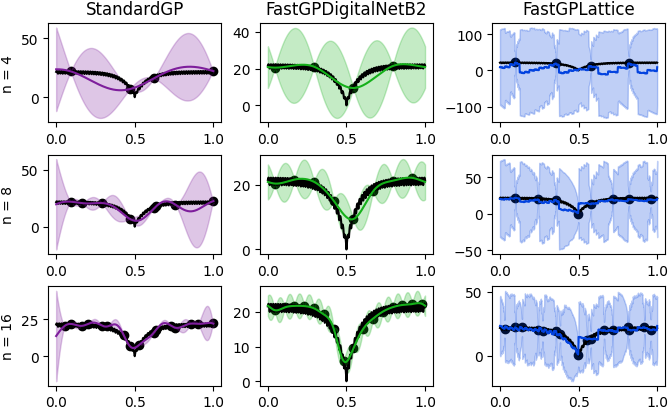

In [16]:
nrows = 3
ncols = len(data[0])
_alpha = 0.25
pyplot.rcParams.update(tueplots.figsizes.icml2024_full(nrows=nrows,ncols=ncols))
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols)
for i in range(3):
    for j in range(ncols):
        x,y,pmean,ci_low,ci_high = data[i][j]
        ax[i,j].plot(xticks.cpu(),yticks.cpu(),color="k")
        ax[i,j].scatter(x[:,0].cpu(),y.cpu(),color="k")
        ax[i,j].plot(xticks.cpu(),pmean.cpu(),color=colors[j])
        ax[i,j].fill_between(xticks.cpu(),ci_low.cpu(),ci_high.cpu(),color=colors[j],alpha=_alpha)
ax[0,0].set_title("StandardGP")
ax[0,1].set_title("FastGPDigitalNetB2")
ax[0,2].set_title("FastGPLattice")
ax[0,0].set_ylabel(r"n = %d"%n)
ax[1,0].set_ylabel(r"n = %d"%(2*n))
ax[2,0].set_ylabel(r"n = %d"%(4*n))
fig.savefig("./gps.pdf")